# Hovmoller plots of NDVI and Rainfall (multiple sites)

__What does this notebook do?__ This notebook opens a shape file of transects and plots hovmoller diagrams of the NDVI based on datacube landsat surface reflectance data and BoM rainfall data.

__Before you run this notebook:__

__you will need:__

  * a shapefile of the site transects in EPSG 4326 in a known location on raijin
  * to use the rainfall data you will need to request access to project r78 on the NCI
  
__Background:__  
The Normalised Difference Vegetation Index [NDVI](https://ieeexplore.ieee.org/abstract/document/1645279/) is a remote sensing index commonly used to 
examine vegetation distribution and condition. Values are between -1 and 1, with values below 0 indicating the presence of water.

$$\begin{eqnarray}
NDVI &=& \frac {(NIR-RED)}{(NIR+RED)}\ \\
\end{eqnarray}$$

__Date:__ June 2018

__Authors:__ Bex Dunn, Leo Lymburner


### Set up modules, functions and libraries

In [ ]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#suppress warnings thrown when rainfall data is imported
# import logging
# logging.getLogger('rasterio._gdal').setLevel(logging.ERROR)
# import warnings

#get standard libraries
import datetime as dt
import fiona
import geopandas as gpd
import shapely.geometry
from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import numpy as np
import os
import pickle
import rasterio
import rasterio.features
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts/'))
import DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#alias for datacube
dc = datacube.Datacube(app='dc-BoMrainfallandNbart')

### Set up functions for this notebook

In [2]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)
def load_rainfall(query):
    
    dc_rf =datacube.Datacube(config='/g/data/r78/bom_grids/rainfall.conf')
    
    rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**query)

    return rf_data

## add the path to the input shapefile

In [3]:
#transects file will be the file containing our transects
transects_file = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/transects/merged2_hovmoller_transects2.shp'
transects_df = gpd.read_file(transects_file)
transects_df

I am densified (27 elements)
I am densified (27 elements)


,OBJECTID,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,...,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,Shape_Leng,Shape_Le_1,geometry
0,1,BasaltR_AmeliaDowns,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.003961,LINESTRING Z (145.3656411224399 -19.6774753714...
1,2,Basalt R Bluff Downs,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.002926,LINESTRING Z (145.5400705400235 -19.6807362331...
2,3,BasaltR_Cargoon,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.006949,LINESTRING Z (144.8968212078325 -20.0068909161...
3,4,BasaltR_Ellenvale,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.001808,LINESTRING Z (144.9768199166059 -19.9179451518...
4,5,BasaltR_JackoCk,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.004456,LINESTRING Z (145.2763820540886 -19.7248906280...
5,6,BasaltR_junction,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.003955,LINESTRING Z (145.8491857987857 -19.6241680068...
6,7,Bull paddock,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.005468,LINESTRING Z (145.3568629325783 -19.6635789024...
7,8,Cuba plains,None,None,None,None,None,1.0,0.0,-1.0,...,0,0,0.0,0,0,None,None,0.000000,0.003044,LINESTRING Z (145.0596251019169 -19.9106655535...
8,9,Expeditiion Ck,None,None,None,None,None,0.0,0.0,0.0,...,0,0,0.0,-1,0,None,None,0.013212,0.013212,LINESTRING Z (145.0406904230247 -18.6861568205...
9,10,Felspar springs,None,None,None,None,None,0.0,0.0,0.0,...,0,0,0.0,-1,0,None,None,0.053353,0.053353,LINESTRING Z (145.2868481832971 -19.8038695461...


## Define the epoch

In [4]:
#Define temporal range
start_of_epoch = '1987-10-01' 
end_of_epoch =  '2017-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2017-10-01


### Retrieve data, plot hovmollers and save to file (this may take some time)

line is not simple, simplifying
BasaltR_AmeliaDowns
BasaltR_AmeliaDowns_ix0
OS error: [Errno 17] File exists: '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_AmeliaDowns_ix0_/'
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_AmeliaDowns_ix0_/hov_data_BasaltR_AmeliaDowns_ix0_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 264 filtered ls5 timesteps
Loading ls7 PQ
    Loading 173 filtered ls7 timesteps
Loading ls8 PQ
    Loading 67 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


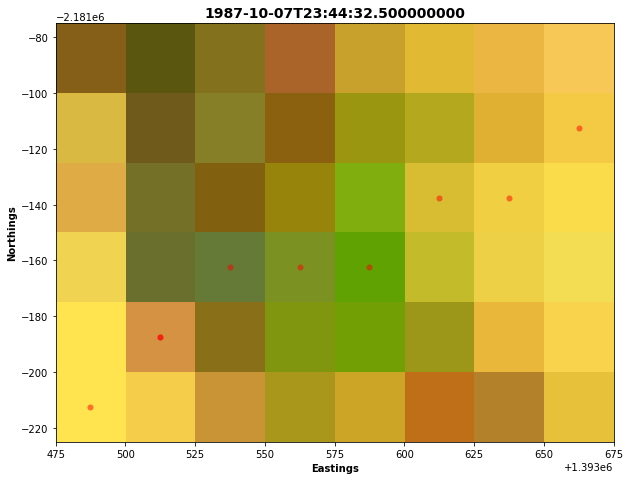

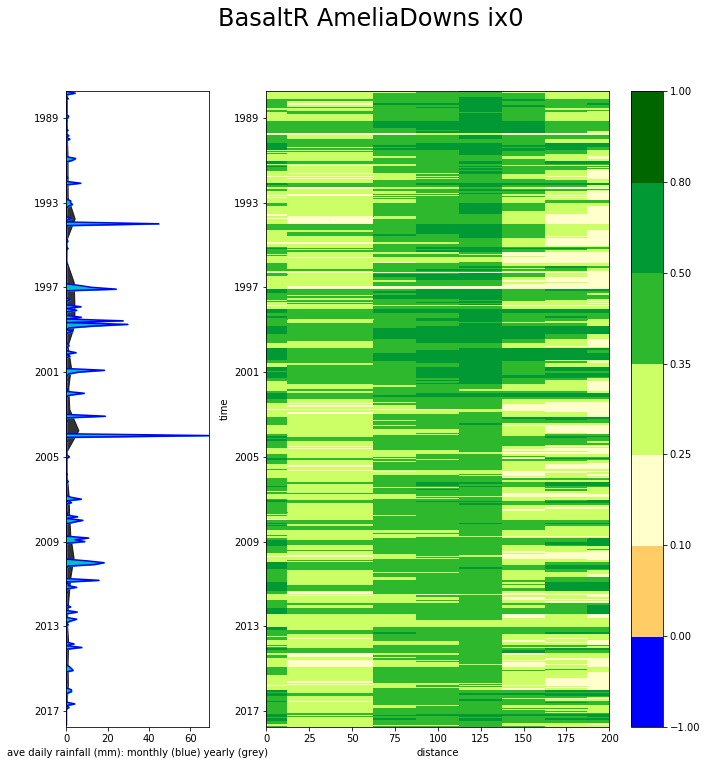

saved data to file
line is not simple, simplifying
Basalt R Bluff Downs
Basalt_R_Bluff_Downs_ix1
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Basalt_R_Bluff_Downs_ix1_/hov_data_Basalt_R_Bluff_Downs_ix1_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 257 filtered ls5 timesteps
Loading ls7 PQ
    Loading 212 filtered ls7 timesteps
Loading ls8 PQ
    Loading 65 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


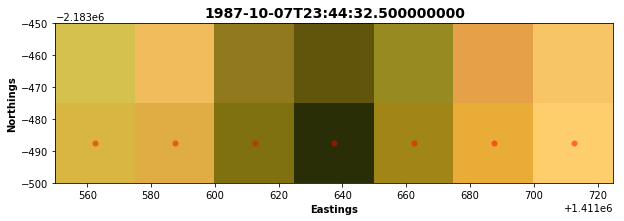

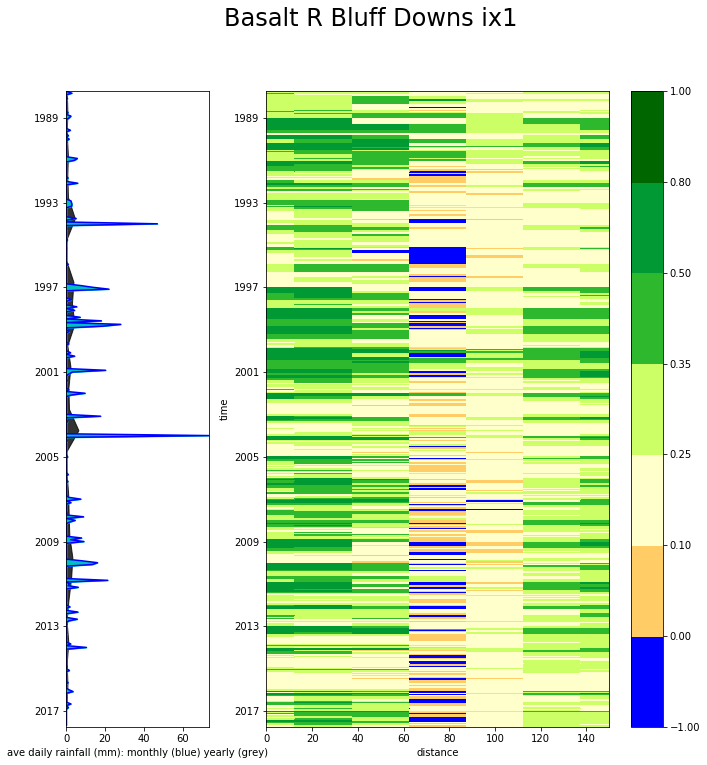

saved data to file
line is not simple, simplifying
BasaltR_Cargoon
BasaltR_Cargoon_ix2
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_Cargoon_ix2_/hov_data_BasaltR_Cargoon_ix2_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 482 filtered ls5 timesteps
Loading ls7 PQ
    Loading 260 filtered ls7 timesteps
Loading ls8 PQ
    Loading 111 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


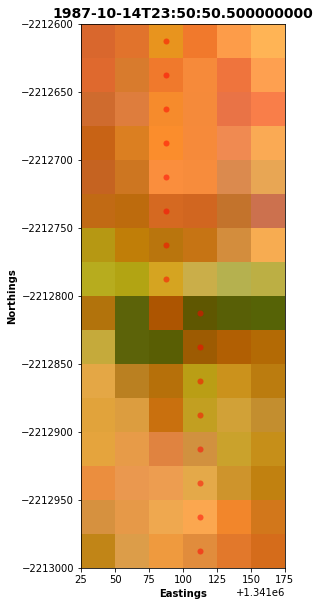

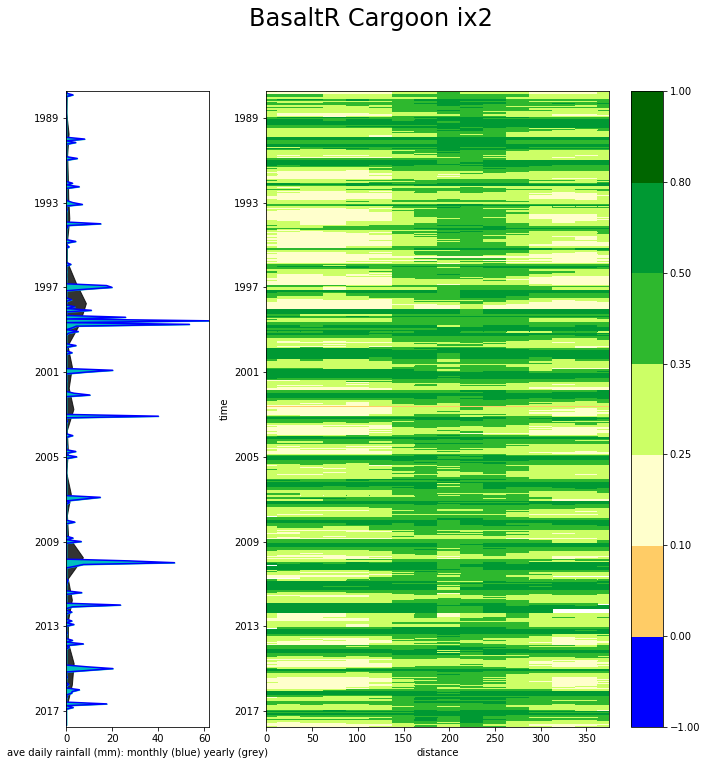

saved data to file
line is not simple, simplifying
BasaltR_Ellenvale
BasaltR_Ellenvale_ix3
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_Ellenvale_ix3_/hov_data_BasaltR_Ellenvale_ix3_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 534 filtered ls5 timesteps
Loading ls7 PQ
    Loading 355 filtered ls7 timesteps
Loading ls8 PQ
    Loading 128 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


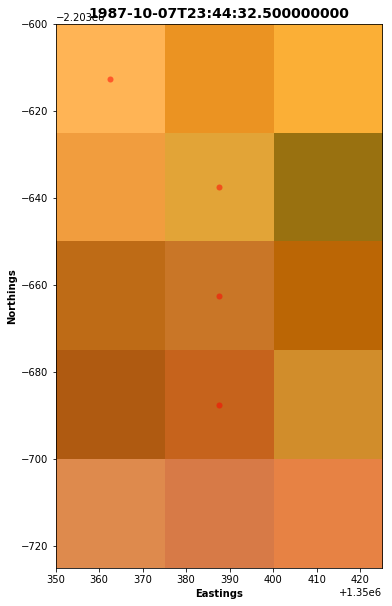

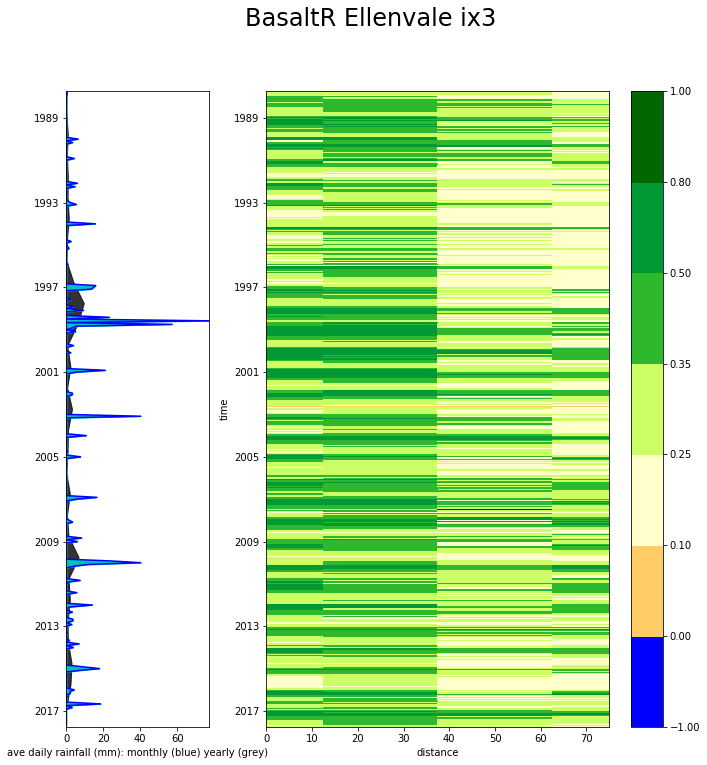

saved data to file
line is not simple, simplifying
BasaltR_JackoCk
BasaltR_JackoCk_ix4
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_JackoCk_ix4_/hov_data_BasaltR_JackoCk_ix4_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 265 filtered ls5 timesteps
Loading ls7 PQ
    Loading 168 filtered ls7 timesteps
Loading ls8 PQ
    Loading 60 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


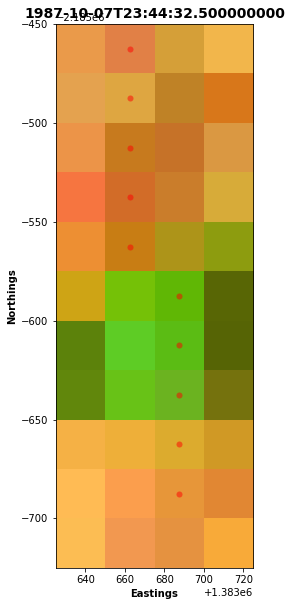

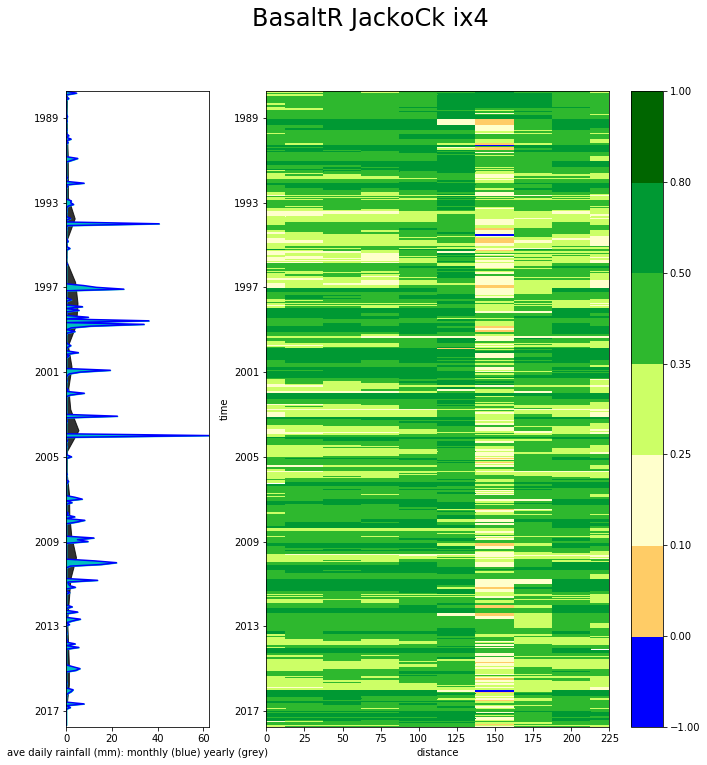

saved data to file
line is not simple, simplifying
BasaltR_junction
BasaltR_junction_ix5
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_junction_ix5_/hov_data_BasaltR_junction_ix5_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 268 filtered ls5 timesteps
Loading ls7 PQ
    Loading 217 filtered ls7 timesteps
Loading ls8 PQ
    Loading 62 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


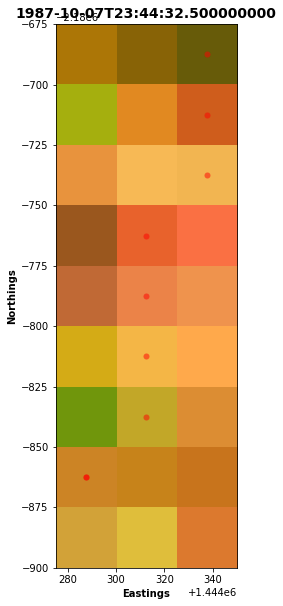

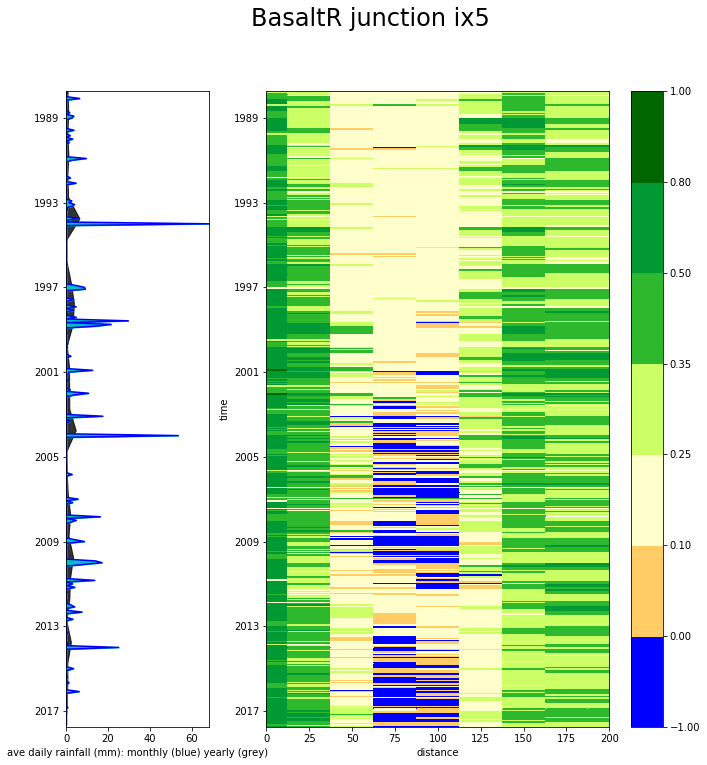

saved data to file
line is not simple, simplifying
Bull paddock
Bull_paddock_ix6
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Bull_paddock_ix6_/hov_data_Bull_paddock_ix6_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 253 filtered ls5 timesteps
Loading ls7 PQ
    Loading 161 filtered ls7 timesteps
Loading ls8 PQ
    Loading 64 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


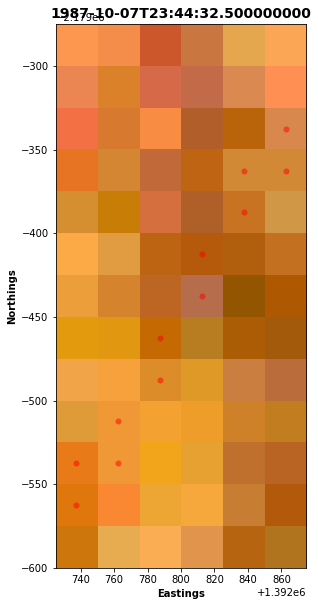

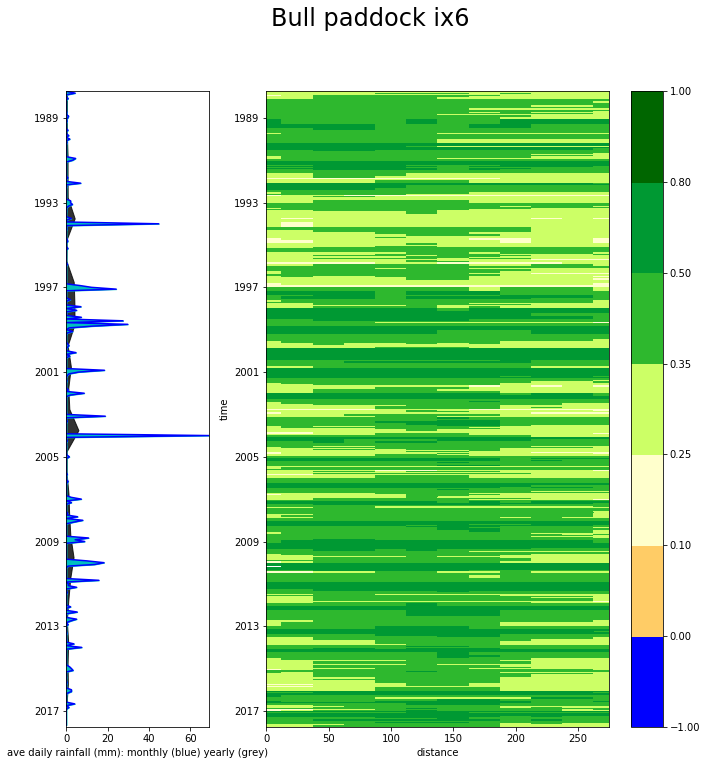

saved data to file
line is not simple, simplifying
Cuba plains
Cuba_plains_ix7
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Cuba_plains_ix7_/hov_data_Cuba_plains_ix7_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 536 filtered ls5 timesteps
Loading ls7 PQ
    Loading 330 filtered ls7 timesteps
Loading ls8 PQ
    Loading 127 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


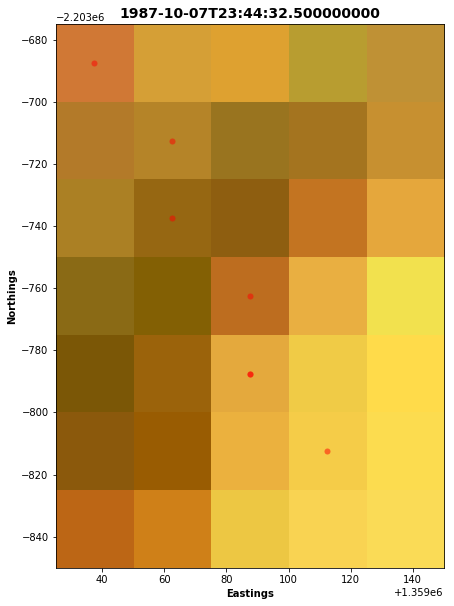

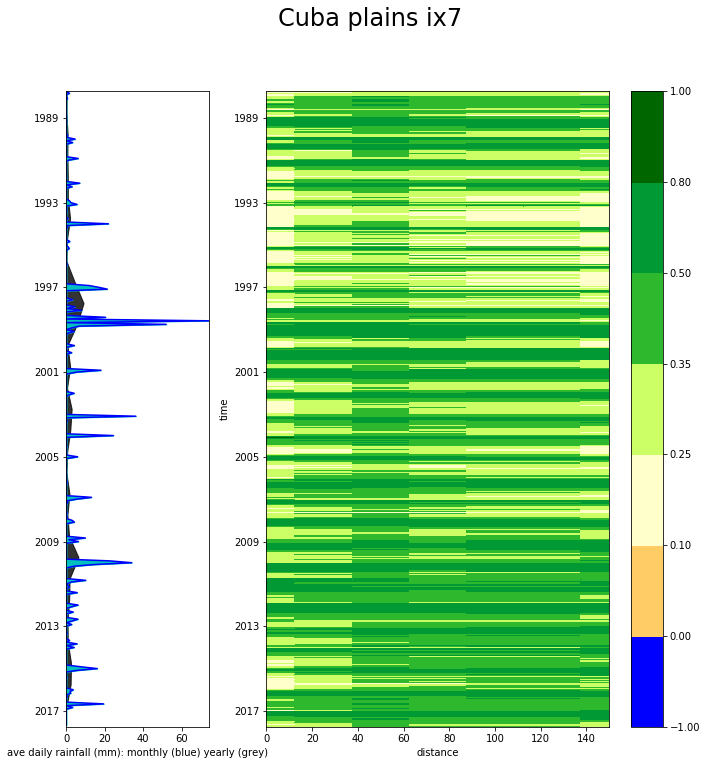

saved data to file
Expeditiion Ck
Expeditiion_Ck_ix8
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Expeditiion_Ck_ix8_/hov_data_Expeditiion_Ck_ix8_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 229 filtered ls5 timesteps
Loading ls7 PQ
    Loading 112 filtered ls7 timesteps
Loading ls8 PQ
    Loading 54 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


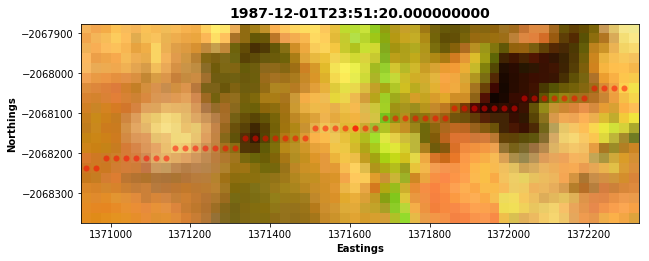

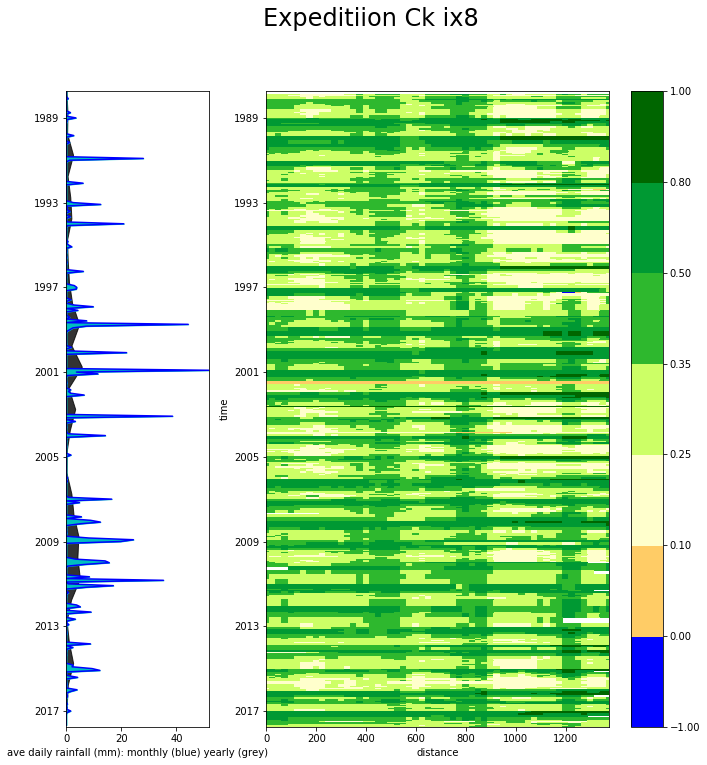

saved data to file
Felspar springs
Felspar_springs_ix9
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Felspar_springs_ix9_/hov_data_Felspar_springs_ix9_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 236 filtered ls5 timesteps
Loading ls7 PQ
    Loading 52 filtered ls7 timesteps
Loading ls8 PQ
    Loading 60 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


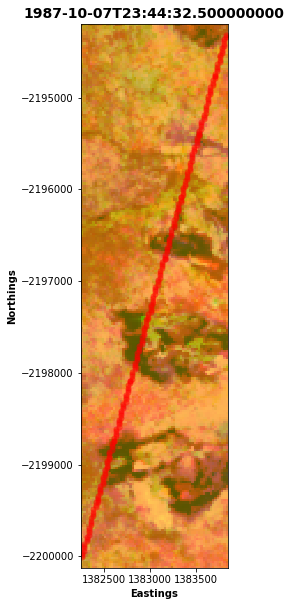

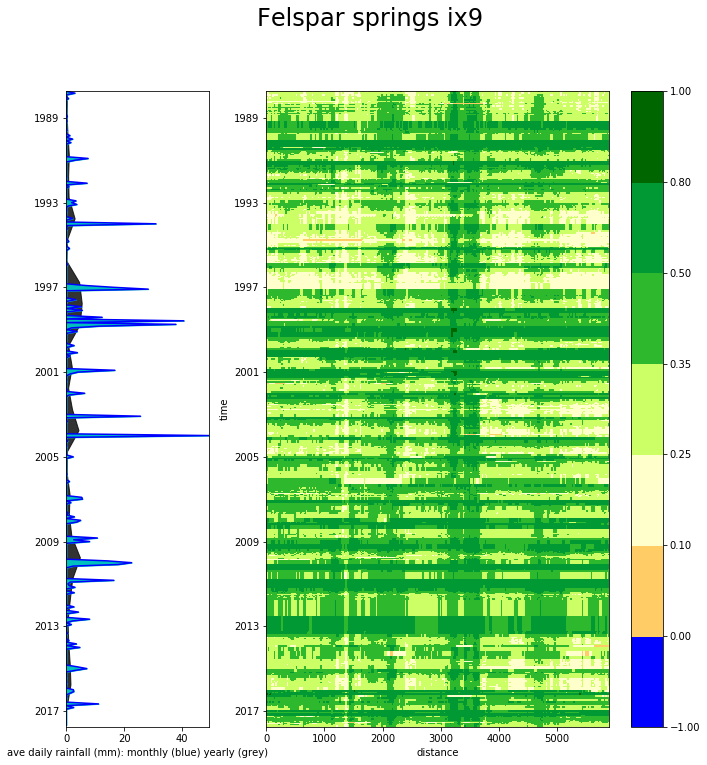

saved data to file
Fletcher Ck
Fletcher_Ck_ix10
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Fletcher_Ck_ix10_/hov_data_Fletcher_Ck_ix10_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 245 filtered ls5 timesteps
Loading ls7 PQ
    Loading 232 filtered ls7 timesteps
Loading ls8 PQ
    Loading 62 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


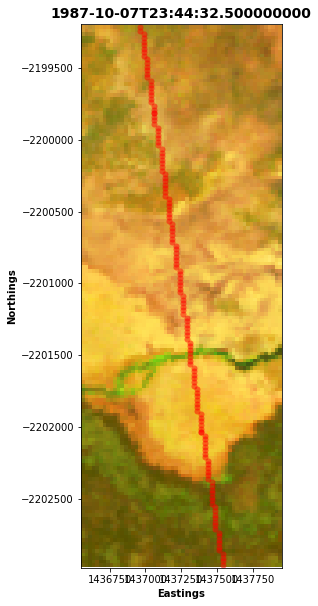

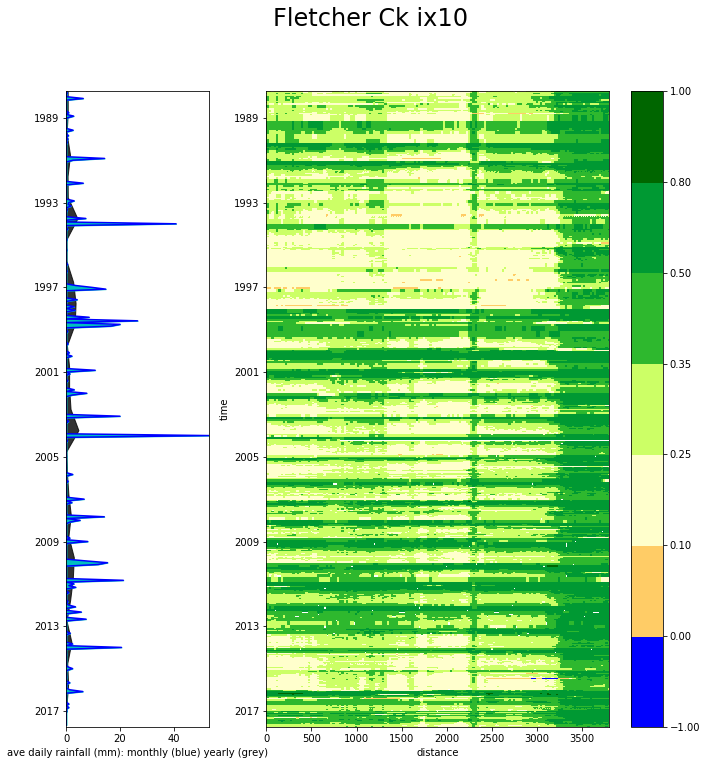

saved data to file
Fossilbrook springs
Fossilbrook_springs_ix11
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Fossilbrook_springs_ix11_/hov_data_Fossilbrook_springs_ix11_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 279 filtered ls5 timesteps
Loading ls7 PQ
    Loading 245 filtered ls7 timesteps
Loading ls8 PQ
    Loading 65 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


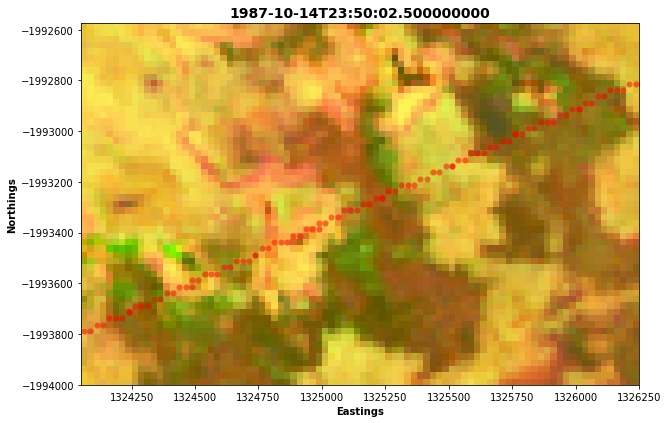

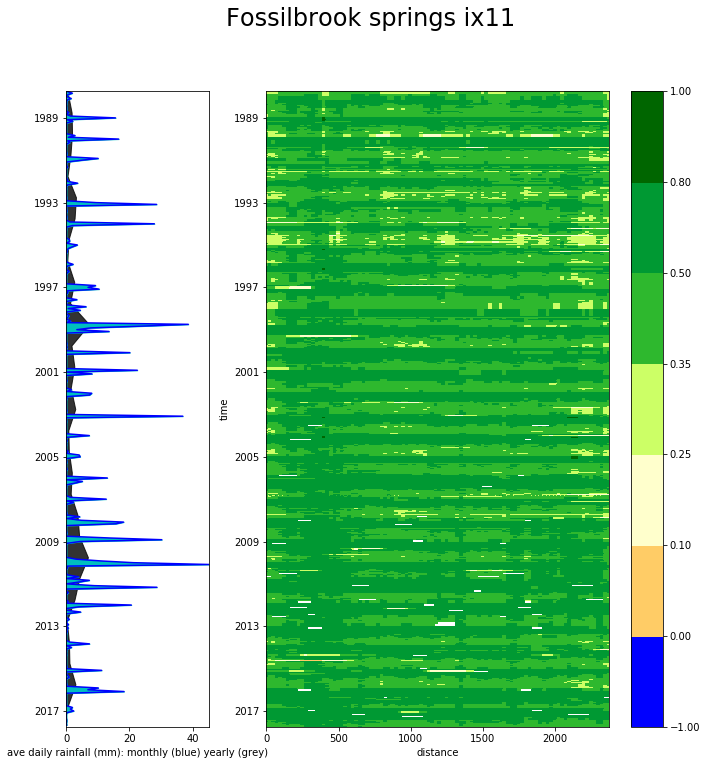

saved data to file
Glenlofty Ck downstream
Glenlofty_Ck_downstream_ix12
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Glenlofty_Ck_downstream_ix12_/hov_data_Glenlofty_Ck_downstream_ix12_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 201 filtered ls5 timesteps
Loading ls7 PQ
    Loading 40 filtered ls7 timesteps
Loading ls8 PQ
    Loading 47 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


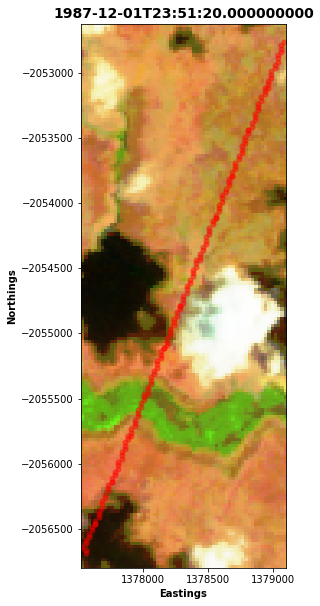

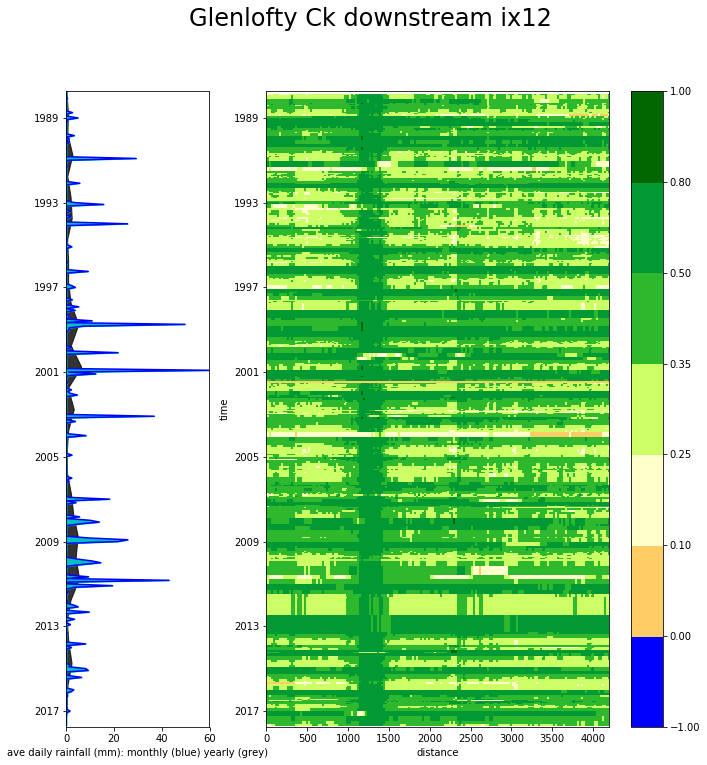

saved data to file
Glenlofty Ck Kinrara
Glenlofty_Ck_Kinrara_ix13
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Glenlofty_Ck_Kinrara_ix13_/hov_data_Glenlofty_Ck_Kinrara_ix13_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 225 filtered ls5 timesteps
Loading ls7 PQ
    Loading 132 filtered ls7 timesteps
Loading ls8 PQ
    Loading 51 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


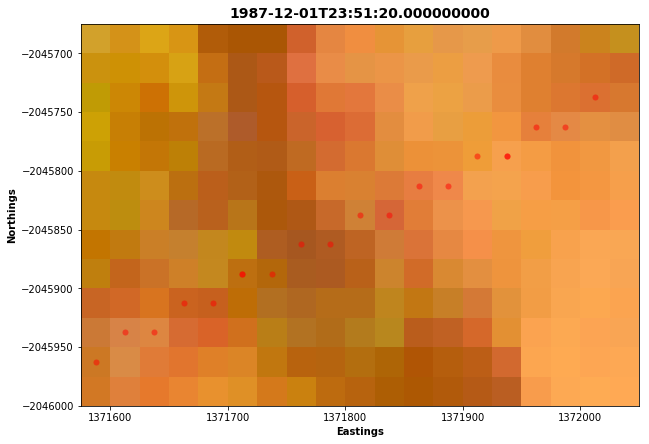

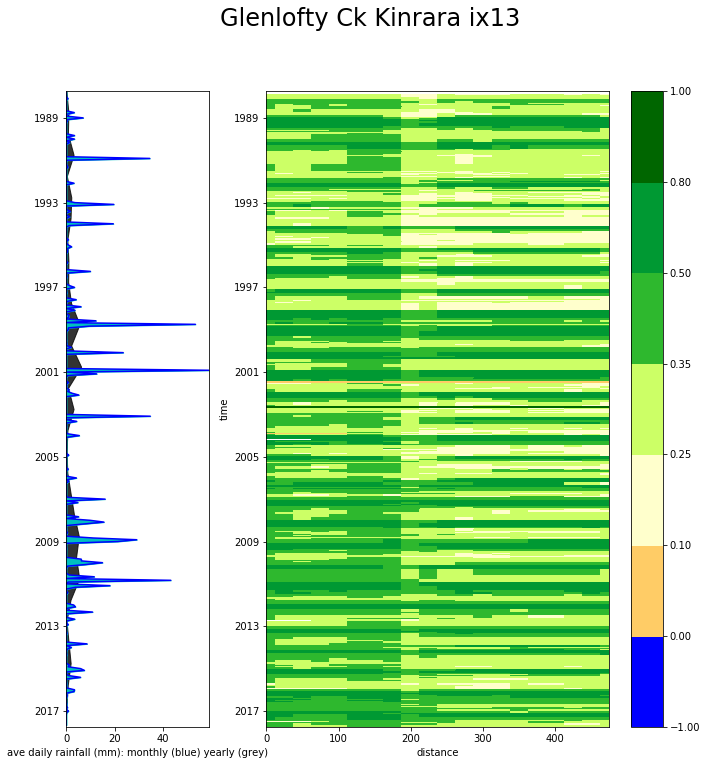

saved data to file
Jacko Creek
Jacko_Creek_ix14
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Jacko_Creek_ix14_/hov_data_Jacko_Creek_ix14_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 247 filtered ls5 timesteps
Loading ls7 PQ
    Loading 53 filtered ls7 timesteps
Loading ls8 PQ
    Loading 60 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


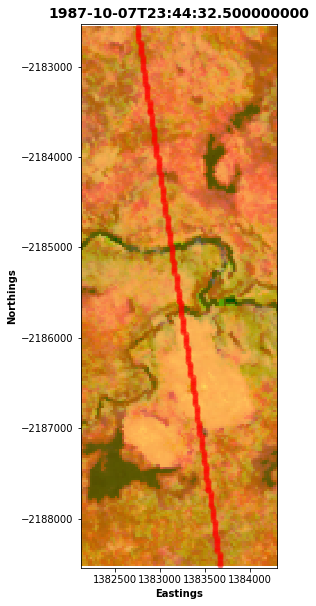

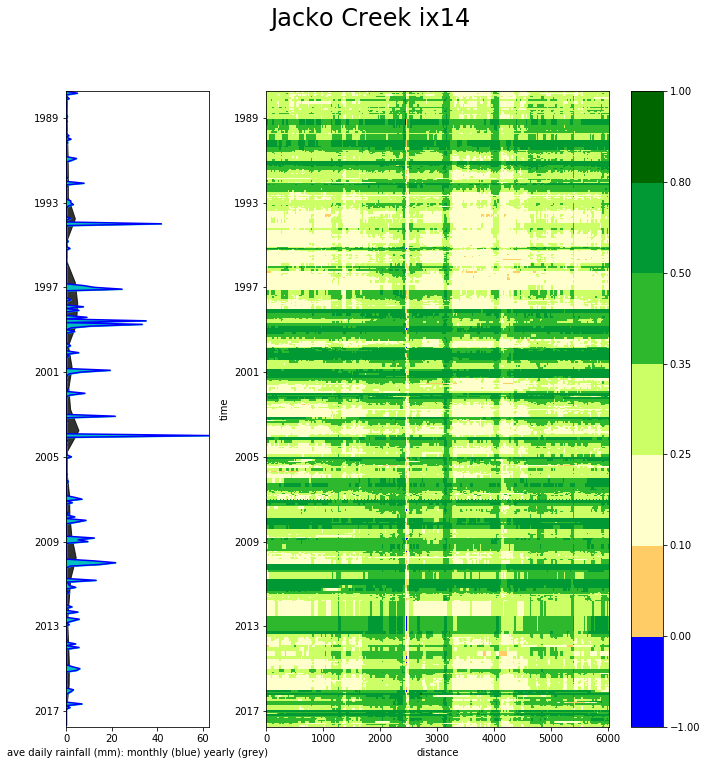

saved data to file
line is not simple, simplifying
Lolworth
Lolworth_ix15
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Lolworth_ix15_/hov_data_Lolworth_ix15_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 559 filtered ls5 timesteps
Loading ls7 PQ
    Loading 344 filtered ls7 timesteps
Loading ls8 PQ
    Loading 133 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


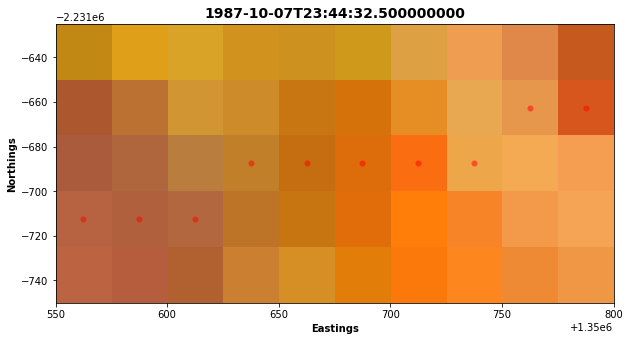

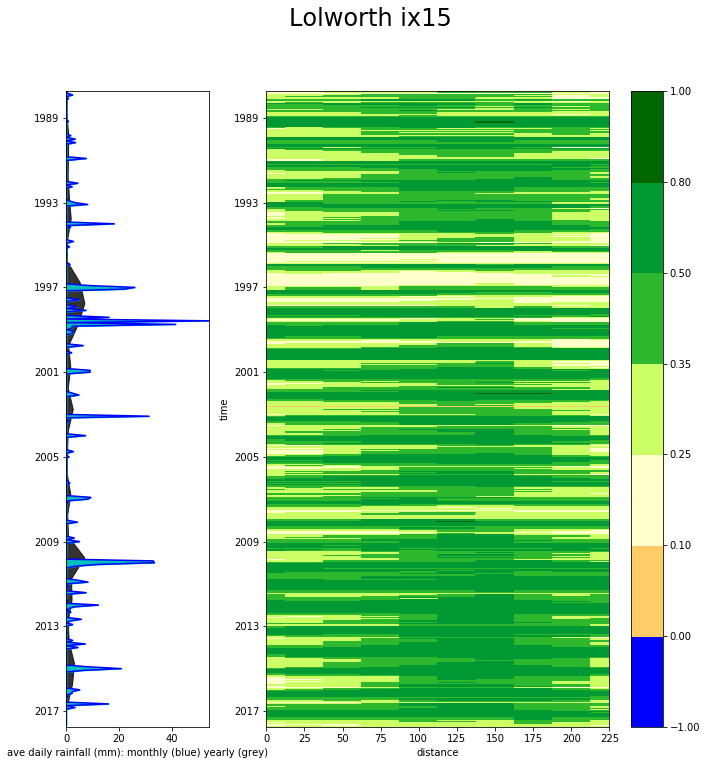

saved data to file
Near Bubbling spring
Near_Bubbling_spring_ix16
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Near_Bubbling_spring_ix16_/hov_data_Near_Bubbling_spring_ix16_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 380 filtered ls5 timesteps
Loading ls7 PQ
    Loading 68 filtered ls7 timesteps
Loading ls8 PQ
    Loading 117 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


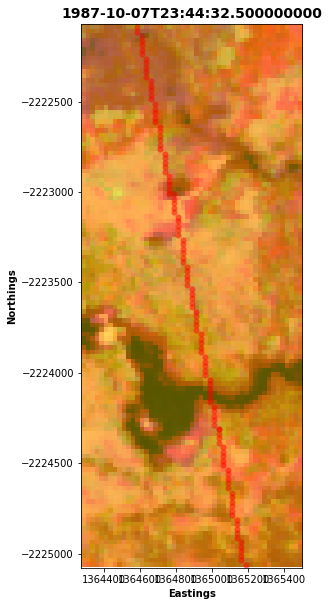

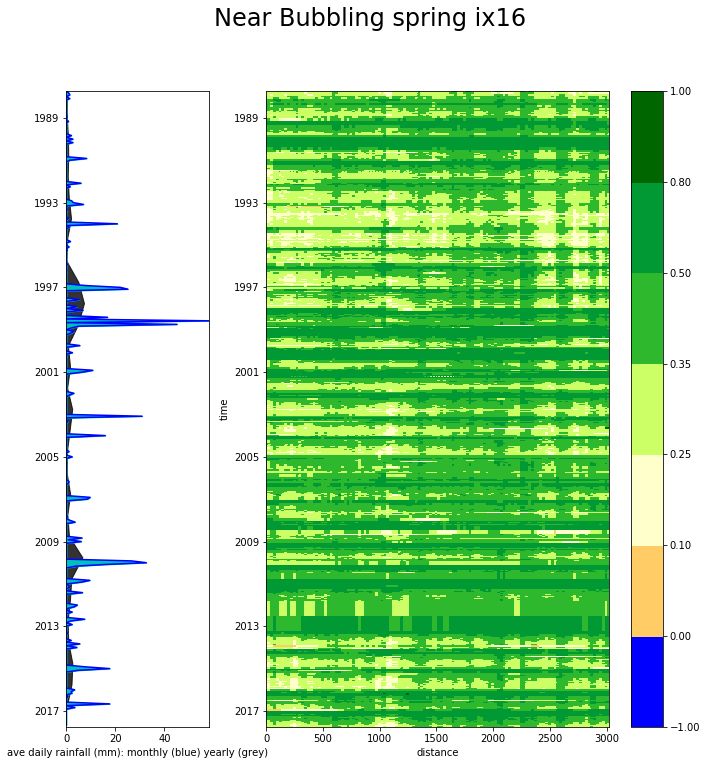

saved data to file
line is not simple, simplifying
Pine Tree
Pine_Tree_ix17
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Pine_Tree_ix17_/hov_data_Pine_Tree_ix17_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 261 filtered ls5 timesteps
Loading ls7 PQ
    Loading 192 filtered ls7 timesteps
Loading ls8 PQ
    Loading 67 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


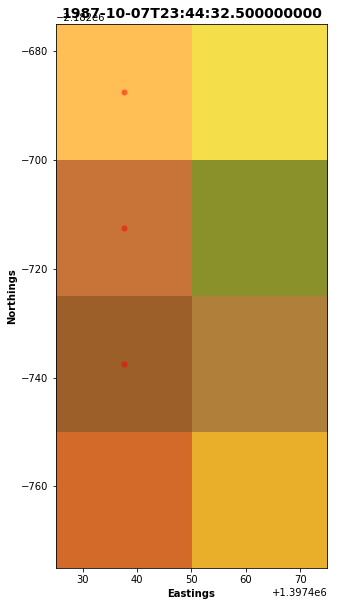

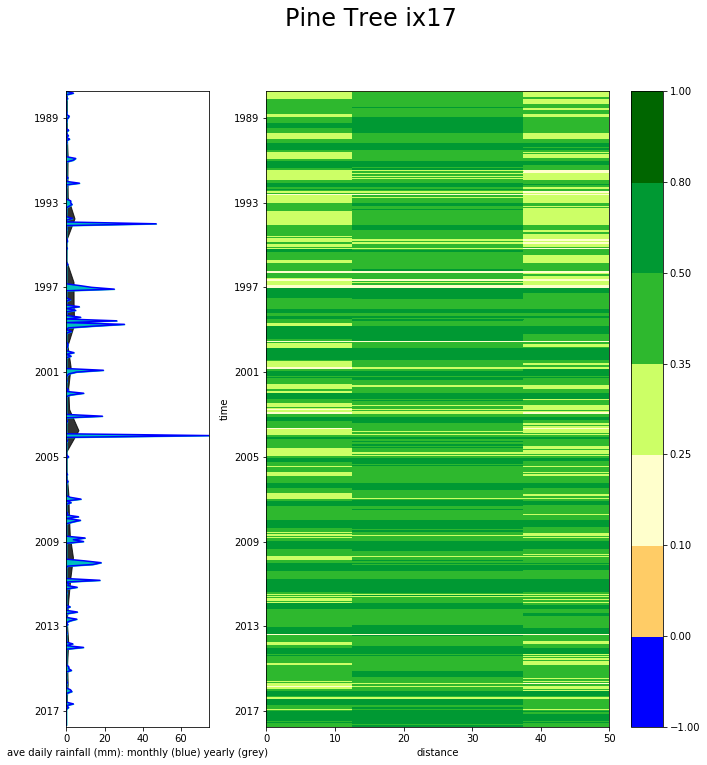

saved data to file
line is not simple, simplifying
Plum tree
Plum_tree_ix18
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Plum_tree_ix18_/hov_data_Plum_tree_ix18_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 258 filtered ls5 timesteps
Loading ls7 PQ
    Loading 182 filtered ls7 timesteps
Loading ls8 PQ
    Loading 66 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


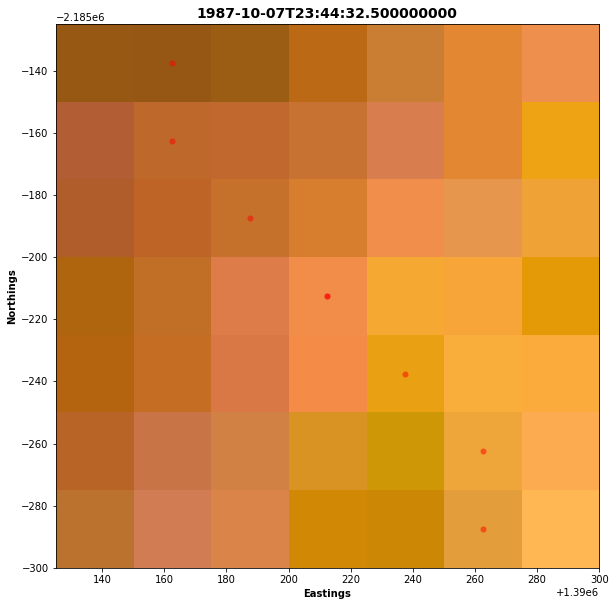

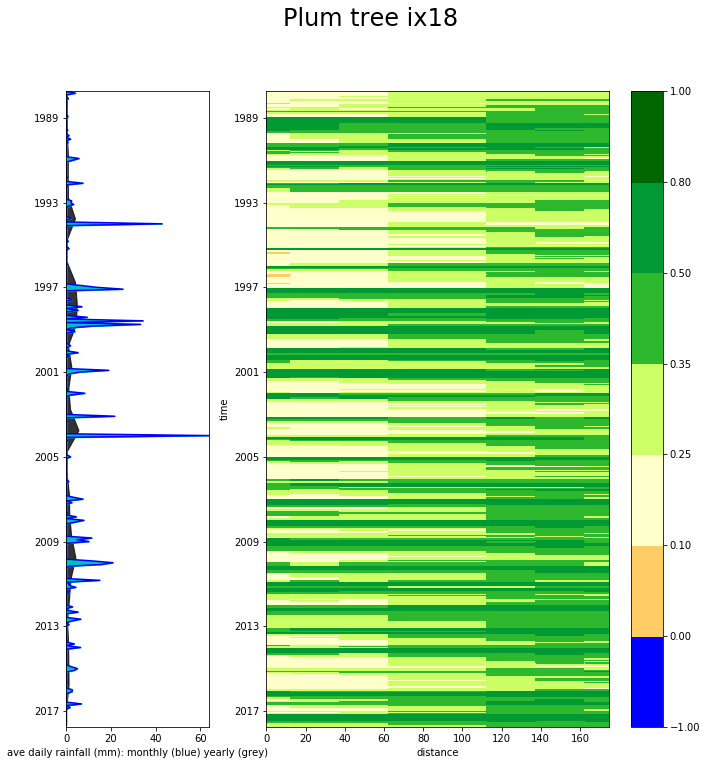

saved data to file
Spring Creek
Spring_Creek_ix19
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Spring_Creek_ix19_/hov_data_Spring_Creek_ix19_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 240 filtered ls5 timesteps
Loading ls7 PQ
    Loading 56 filtered ls7 timesteps
Loading ls8 PQ
    Loading 60 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


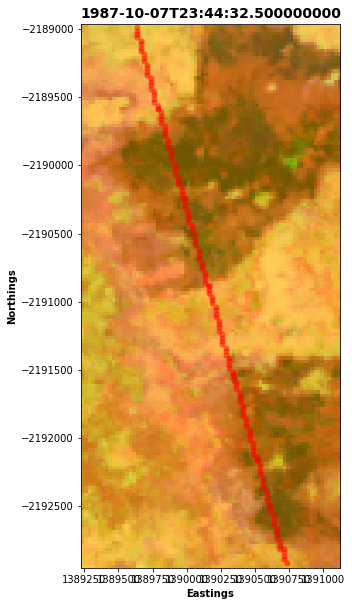

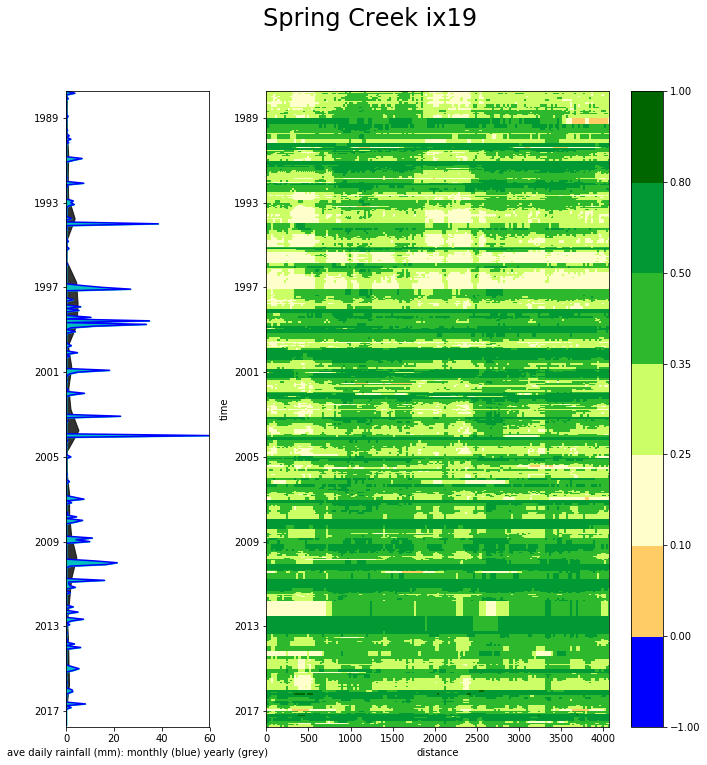

saved data to file
Spring Ck McBride
Spring_Ck_McBride_ix20
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Spring_Ck_McBride_ix20_/hov_data_Spring_Ck_McBride_ix20_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 251 filtered ls5 timesteps
Loading ls7 PQ
    Loading 227 filtered ls7 timesteps
Loading ls8 PQ
    Loading 65 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


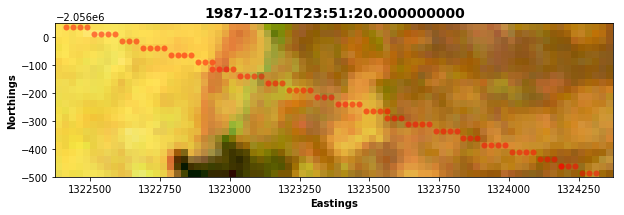

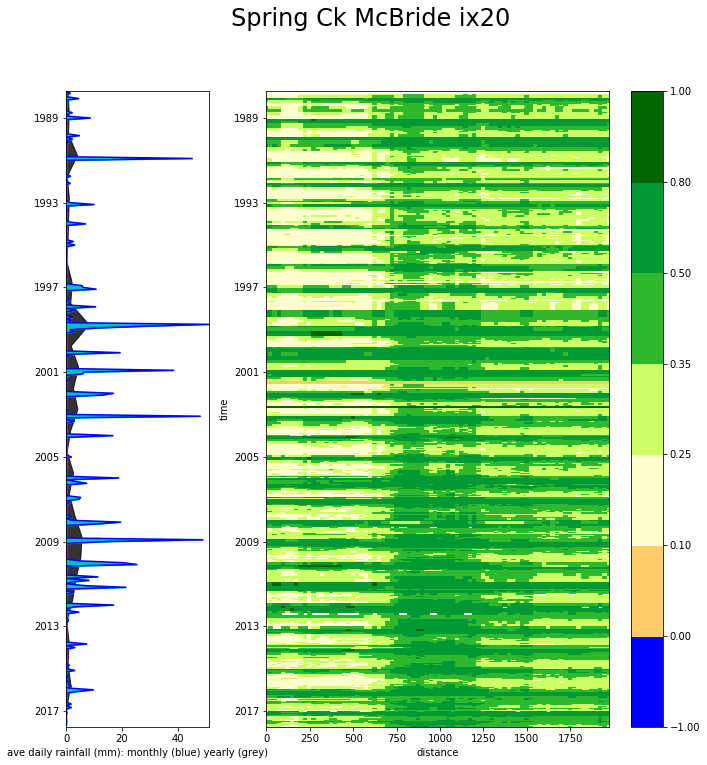

saved data to file
Talavera Creek
Talavera_Creek_ix21
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Talavera_Creek_ix21_/hov_data_Talavera_Creek_ix21_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 250 filtered ls5 timesteps
Loading ls7 PQ
    Loading 90 filtered ls7 timesteps
Loading ls8 PQ
    Loading 59 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


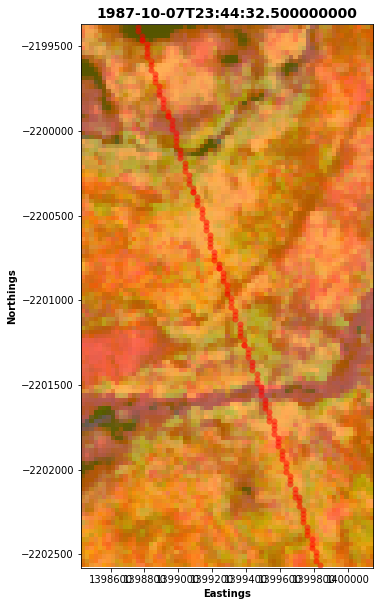

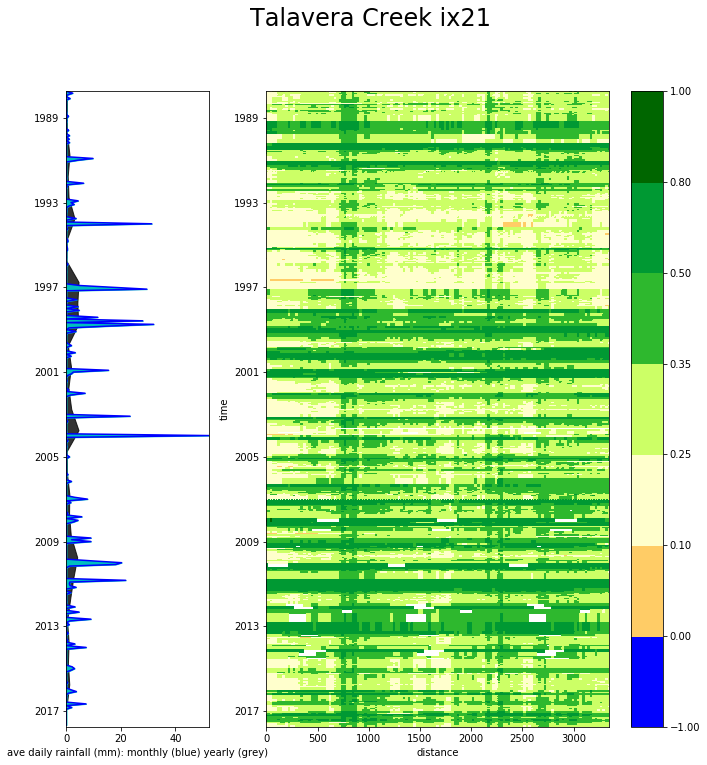

saved data to file
line is not simple, simplifying
Talavera
Talavera_ix22
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Talavera_ix22_/hov_data_Talavera_ix22_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 263 filtered ls5 timesteps
Loading ls7 PQ
    Loading 189 filtered ls7 timesteps
Loading ls8 PQ
    Loading 68 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


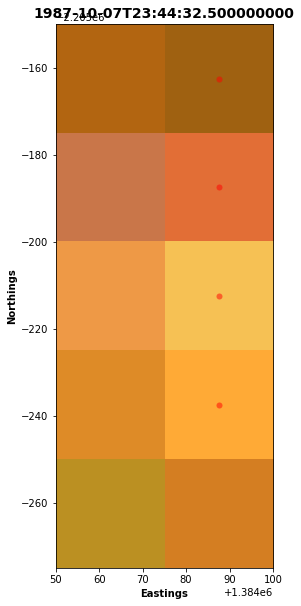

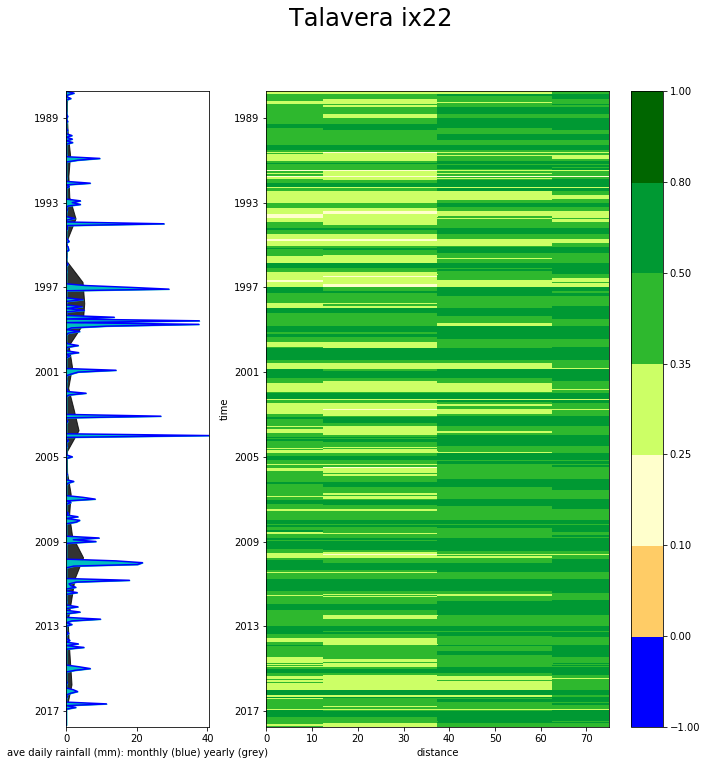

saved data to file
The Brook
The_Brook_ix23
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/The_Brook_ix23_/hov_data_The_Brook_ix23_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 397 filtered ls5 timesteps
Loading ls7 PQ
    Loading 137 filtered ls7 timesteps
Loading ls8 PQ
    Loading 122 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


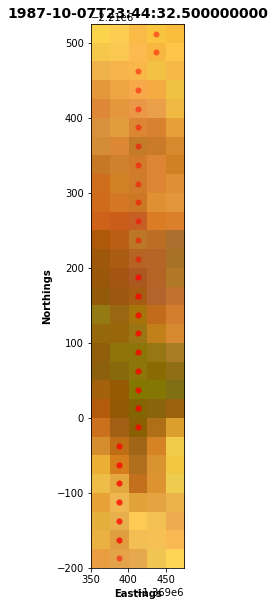

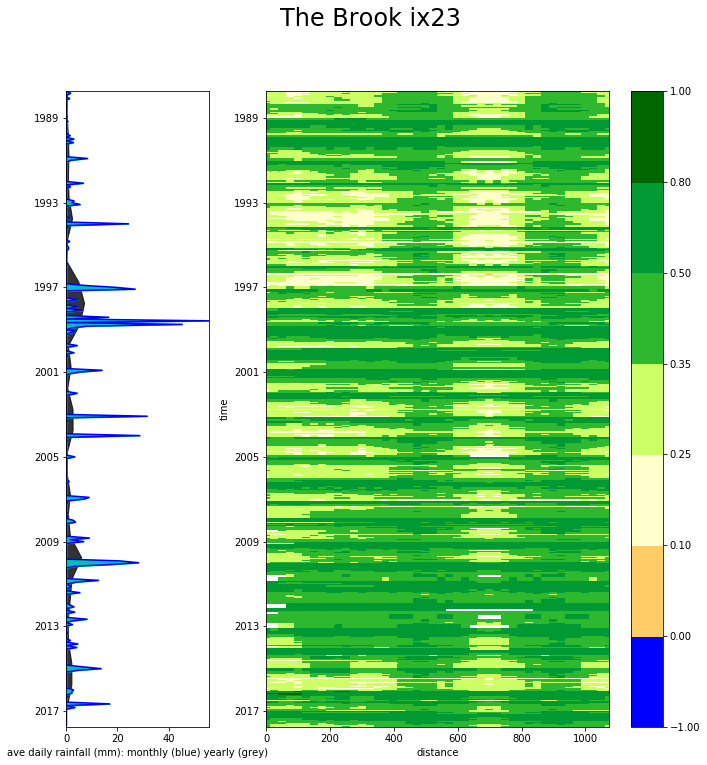

saved data to file
line is not simple, simplifying
Toomba 2
Toomba_2_ix24
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Toomba_2_ix24_/hov_data_Toomba_2_ix24_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 266 filtered ls5 timesteps
Loading ls7 PQ
    Loading 174 filtered ls7 timesteps
Loading ls8 PQ
    Loading 60 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


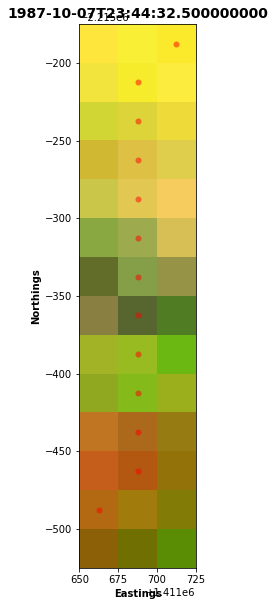

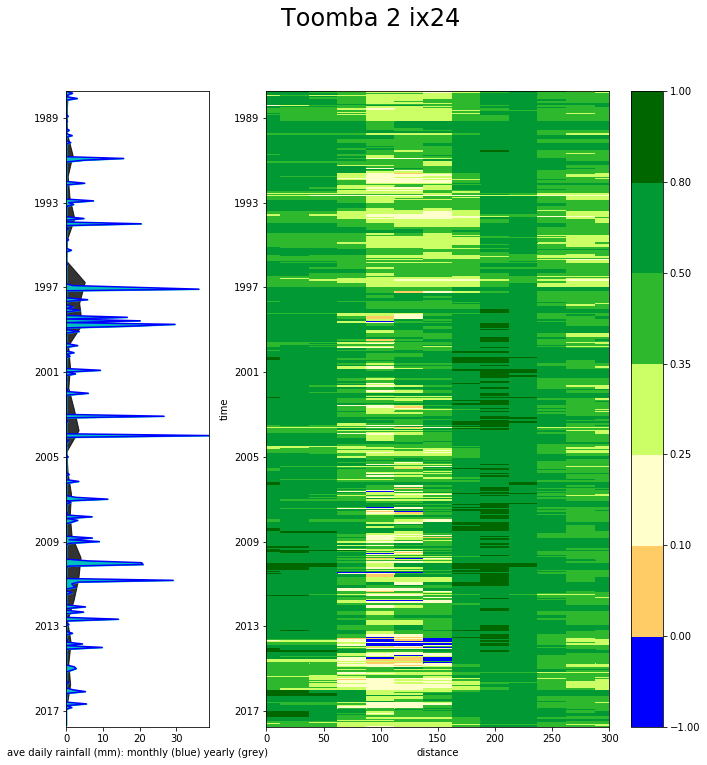

saved data to file
line is not simple, simplifying
W Ck
W_Ck_ix25
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/W_Ck_ix25_/hov_data_W_Ck_ix25_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 251 filtered ls5 timesteps
Loading ls7 PQ
    Loading 184 filtered ls7 timesteps
Loading ls8 PQ
    Loading 68 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


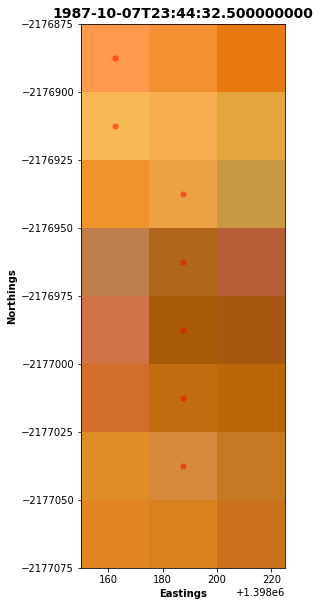

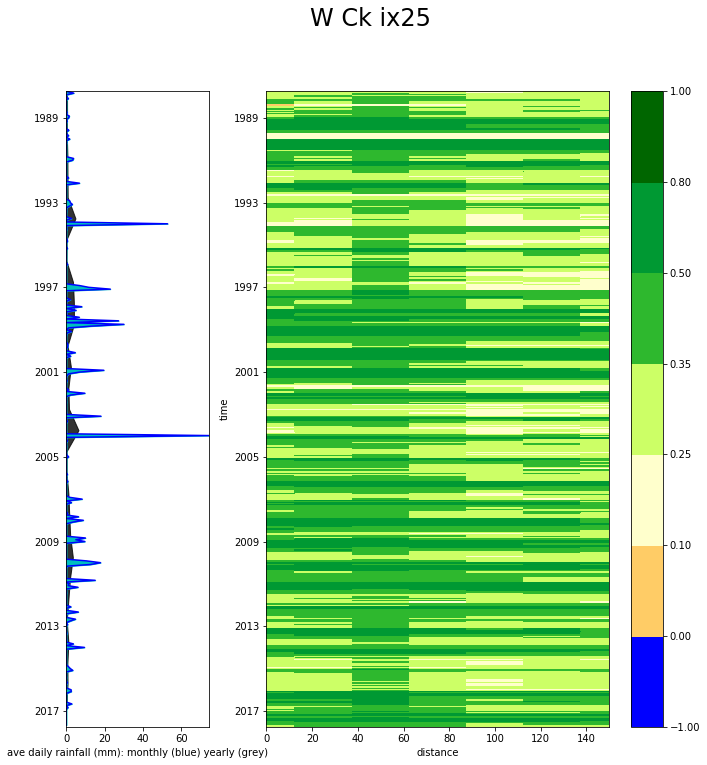

saved data to file
Glendhu
Glendhu_ix26
/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/Glendhu_ix26_/hov_data_Glendhu_ix26_1987-10-01_2017-10-01.pkl
did not load data from previous run
Loading ls5 PQ
    Loading 217 filtered ls5 timesteps
Loading ls7 PQ
    Loading 37 filtered ls7 timesteps
Loading ls8 PQ
    Loading 45 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded data from DEA
loaded bom rainfall grids from DEA


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


transect image: 


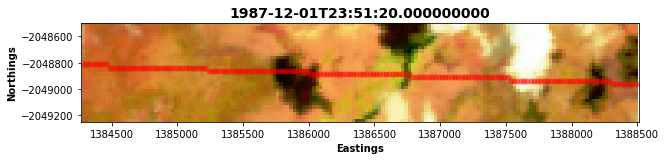

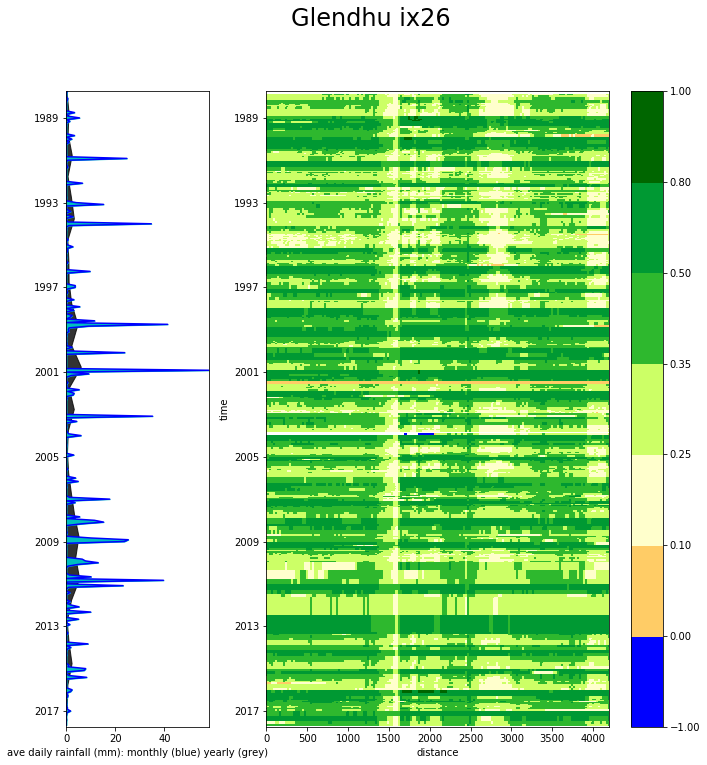

saved data to file


In [5]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

# #this statement asks you to choose a shapefile. put in a number and press enter.
# i = int(input("choose the index of the transect you would like to plot:"))
for i in range(len(transects)):

    geom1 = shape(transects[i]['geometry'])
    #if the geometry is not unique, make it unique!
    if not geom1.is_simple:
    #test to see if our linestring is a simple line --- some of these lines
    #went back on themselves
        print('line is not simple, simplifying')
        geom1 = geom1.intersection(geom1)
    geom_query1 = geom_query(geom1)
    query = {
        'time': (start_of_epoch, end_of_epoch),  
    }
    query.update(geom_query(geom1, geom_crs=transects.crs_wkt)) 

### use the transect dataframe to get transect metadata

    #use the transect dataframe to get transect metadata
    transect_index = transects_df.index[i]
    transect_name = transects_df['Name'][i] 
    try:
        print(transect_name)
    except TypeError as err:
        print("TypeError: {0}".format(err))
        print(transect_name)

    #create a filename for the transect
    shape_name = transect_name.split()
    shape_name ='_'.join(shape_name)
    shape_name=shape_name+'_ix'+str(transect_index)
    print(shape_name)

    #setup a save directory for our data
    savepath ='/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/'+shape_name+'_/'
    try:
            os.mkdir(savepath)
    except OSError as err:
            print("OS error: {0}".format(err))

### Check if this notebook has already been run and the data saved:

    print(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl')

### If not, pull in rainfall and nbar 

    if os.path.isfile(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl'):
        f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'rb')
        hov_data = pickle.load(f) 
        f.close()
        if hov_data is not None: 
            print('loaded data from file')
            ds = hov_data['ds']
            Studysite_rain=hov_data['Studysite_rain']

    else:
        print('did not load data from previous run')
        #use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
        ds = DEADataHandling.load_clearlandsat(dc, query,product='nbart',masked_prop=0.80)
        print('loaded data from DEA')
        #Grab bom_rainfall_grids from the datacube
        Studysite_rain = load_rainfall(query)
        print('loaded bom rainfall grids from DEA')

### resample gridded rainfall data

    #resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
    #Note that the resampling we did means that each year is labelled according to its first day  
    rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
    month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
    year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
    # Create a spatial average
    year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

### Set up some colour maps for the Hovmoller plots

    #This controls the colour map used for plotting NDVI
    ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
    ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
    #Be aware that clip = True might be causing issues
    ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

### Set up data for Hovmoller plots and calculate NDVI

### Build 2D transect dataset for hovmoller plot
    crs = ds.crs
    crs_wkt = ds.crs.wkt
    geom_w = warp_geometry(geom1, query['crs'], crs_wkt)
    hov_ds= transect(ds, geom_w, 25)

    #calculate NDVI here
    hov_multi_ndvi = ((hov_ds.nir-hov_ds.red)/(hov_ds.nir+hov_ds.red))
    hov_multi =hov_ds
    hov_multi_ndvi_drop = hov_multi_ndvi

### Make Hovmoller plot

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #try plotting the first clean time slice to see where we are
        print('transect image: ')
        DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
        plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
                   linewidths='0.01', alpha = 0.5)
        plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
                bbox_inches='tight')
        plt.show()
        

        #Make a hovmoller plot and save it to file.
        #Use firstyear and last year to zoom into periods of interest
        firstyearhov = start_of_epoch#'1987-06-01'
        lastyearhov = end_of_epoch #'2016-12-31'
        fig = plt.figure(figsize=(11.27,11.69))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
        ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

        #set up fill time as a datetime 64 object for matplotlib input
        #set up variables to plot the fill behind the yearly rain data
        filltime = (year_avg_sp.time.astype('datetime64'))
        zeros = np.zeros(shape=(len(filltime)))
        plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
        #set up variables to plot the fill behind the months data
        mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
        plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
        plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

        ax2 = plt.subplot(gs[0, 1])
        hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
        #fig.delaxes(fig.axes[]) #remove current colour bar
        plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
        ax2.set_anchor("SE")
        #make a title replacing underscores with spaces
        plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

        #save plot to file
        plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
                    bbox_inches='tight')
        plt.show()

### Save the data to an output file for future use

    try:
        #make a dictionary of the data we want to save
        hov_data = {'ds':ds, 'Studysite_rain':Studysite_rain,'rain_sp':rain_sp,'month_sp':month_sp,
                    'year_avg':year_avg,'year_avg_sp':year_avg_sp,'hov_ds':hov_ds, 'start_of_epoch': start_of_epoch, 
                    'end_of_epoch':end_of_epoch,'ndvi_cmap':ndvi_cmap, 'ndvi_norm':ndvi_norm, 'ndvi_bounds':ndvi_bounds}

        f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'wb')
        pickle.dump(hov_data,f) 
        print('saved data to file')
        #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
        f.close()
    except:
        print('did not save to file')